# 08- Regression linéaire

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

from joblib import dump, load # pour enregistrer et charger les modèles.

from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

n_coeurs = 4

In [60]:
# Instanciation df
df = pd.read_csv('ready_Cloud9am_Cloud3pm.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['WindGustSpeed', 'Date', 'NonMesNum']).copy()
y = df['WindGustSpeed'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

# Scale de X_train, X_test:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

## 1.Regression linéaire multiple

In [61]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [62]:
############ Cross Val Score ############
print("R² sur LR train:", round(lr.score(X_train, y_train), 2))
print("R² sur LR test, cross validate: ", round(cross_val_score(lr, X_train, y_train, cv = 5).mean(), 2))

R² sur LR train: 0.71
R² sur LR test, cross validate:  0.71


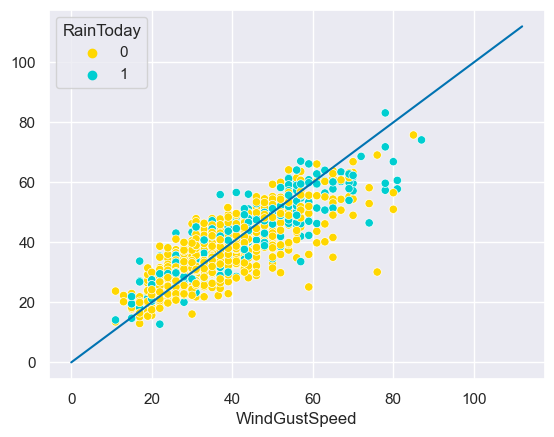

In [64]:
y_pred_test = lr.predict(X_test)
sns.scatterplot(x = y_test, y = y_pred_test, hue = X_test['RainToday'], palette = ['gold', 'darkturquoise'])
plt.plot(np.arange(0, y.max()), np.arange(0, y.max()))
plt.show()

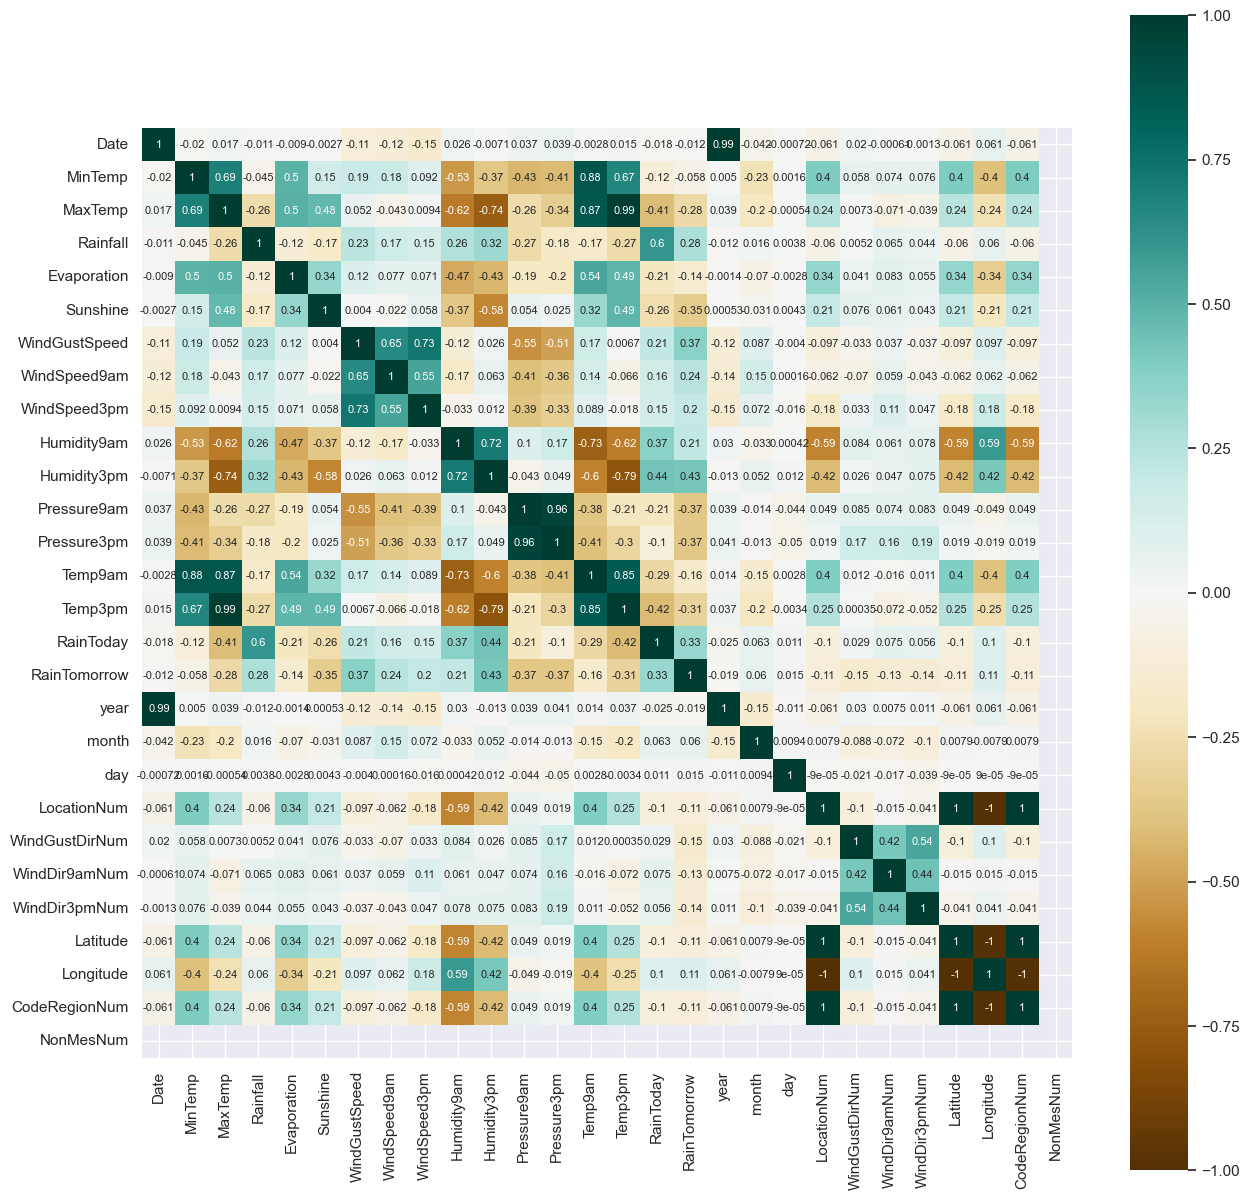

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, center = 0, cmap = 'BrBG', annot_kws={"size":8}, square = True)
plt.show()

In [55]:
signif_features = ['WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm', 'RainTomorrow']

lr2 = LinearRegression()
lr2.fit(X_train[signif_features], y_train) # on fit seulement sur les variables significatives

print("R² de LR signifiant features train:", round(lr2.score(X_train[signif_features], y_train), 2))
print("R² de LR signifiant features test:", round(lr2.score(X_test[signif_features], y_test), 2))

R² de LR signifiant features train: 0.69
R² de LR signifiant features test: 0.68


In [54]:
################ SelectKBest  ####################

sk = SelectKBest(f_regression, k = 5) # on sélectionne les 3 variables les plus significatives, évaluées par une fonction de score, 
                                      #ici f_regression
sk.fit(X, y)
print(X.columns[sk.get_support()])   # renvoie la liste des k variables les plus importantes.

sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test) 

sklr = LinearRegression()
sklr.fit(sk_train, y_train)
print("Score R² sur les données d'entrainement sélectionnées par SKBest:",  round(sklr.score(sk_train, y_train), 2))
print("Score R² sur les données de test sélectionnéespar SKBest:",  round(sklr.score(sk_test, y_test), 2))

Index(['WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm',
       'RainTomorrow'],
      dtype='object')
Score R² sur les données d'entrainement sélectionnées par SKBest: 0.69
Score R² sur les données de test sélectionnéespar SKBest: 0.68


In [181]:
def linreg(mesure, scale):
    # Séparation data / target:
    X = df.drop(columns = [mesure, 'Date', 'NonMesNum']).copy()
    y = df[mesure].copy()

    # Séparation du jeu d'entrainement et du jeu de test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
    
    # Scale des grandeurs:
    
    if scale == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    else:
        X_train = X_train
        X_test = X_test
        
    # Entrainement du modèle:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
        
    # Evaluation:
    score_train = round(lr.score(X_train, y_train), 2)
    score_test = round(cross_val_score(lr, X_train, y_train, cv = 5).mean(), 2)
    #print("R² sur LR train:", score_train)
    #print("R² sur LR test, cross validate: ", score_test)
    
    # Graphique:
    y_pred_test = lr.predict(X_test)
    plt.figure(figsize = (5, 5))
    sns.scatterplot(x = y_test, y = y_pred_test, hue = X_test['RainToday'], palette = ['gold', 'darkturquoise'])
    plt.plot(np.arange(y.min(), y.max()), np.arange(y.min(), y.max()))
    plt.xlabel('Réalité')
    plt.ylabel('Prédiction')
    plt.title('Modélisation de ' +str(mesure)+ ':')
    plt.text(y.max()*0.6, y.max()*0.15,  "R² sur LR train: " + str(score_train))
    plt.text(y.max()*0.6, y.max()*0.05,  "R² sur LR test CV : " + str(score_test))
    plt.show()

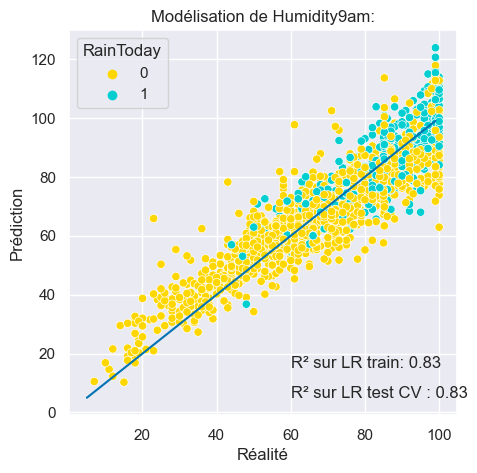

In [190]:
linreg('Humidity9am', False)

In [151]:
to_plot = ['Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'WindSpeed9am', 'WindSpeed3pm']

In [206]:
def linreg_plot(mesure, scale):
    # Séparation data / target:
    X = df.drop(columns = [mesure, 'Date', 'NonMesNum']).copy()
    y = df[mesure].copy()

    # Séparation du jeu d'entrainement et du jeu de test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
    
    # Scale des grandeurs:
    
    if scale == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    else:
        X_train = X_train
        X_test = X_test
        
    # Entrainement du modèle:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
        
    # Evaluation:
    score_train = round(lr.score(X_train, y_train), 2)
    score_test = round(cross_val_score(lr, X_train, y_train, cv = 5).mean(), 2)
    #print("R² sur LR train:", score_train)
    #print("R² sur LR test, cross validate: ", score_test)
    
    # Graphique:
    y_pred_test = lr.predict(X_test)
    
    return (y_test, y_pred_test, score_train, score_test, X_test, y)

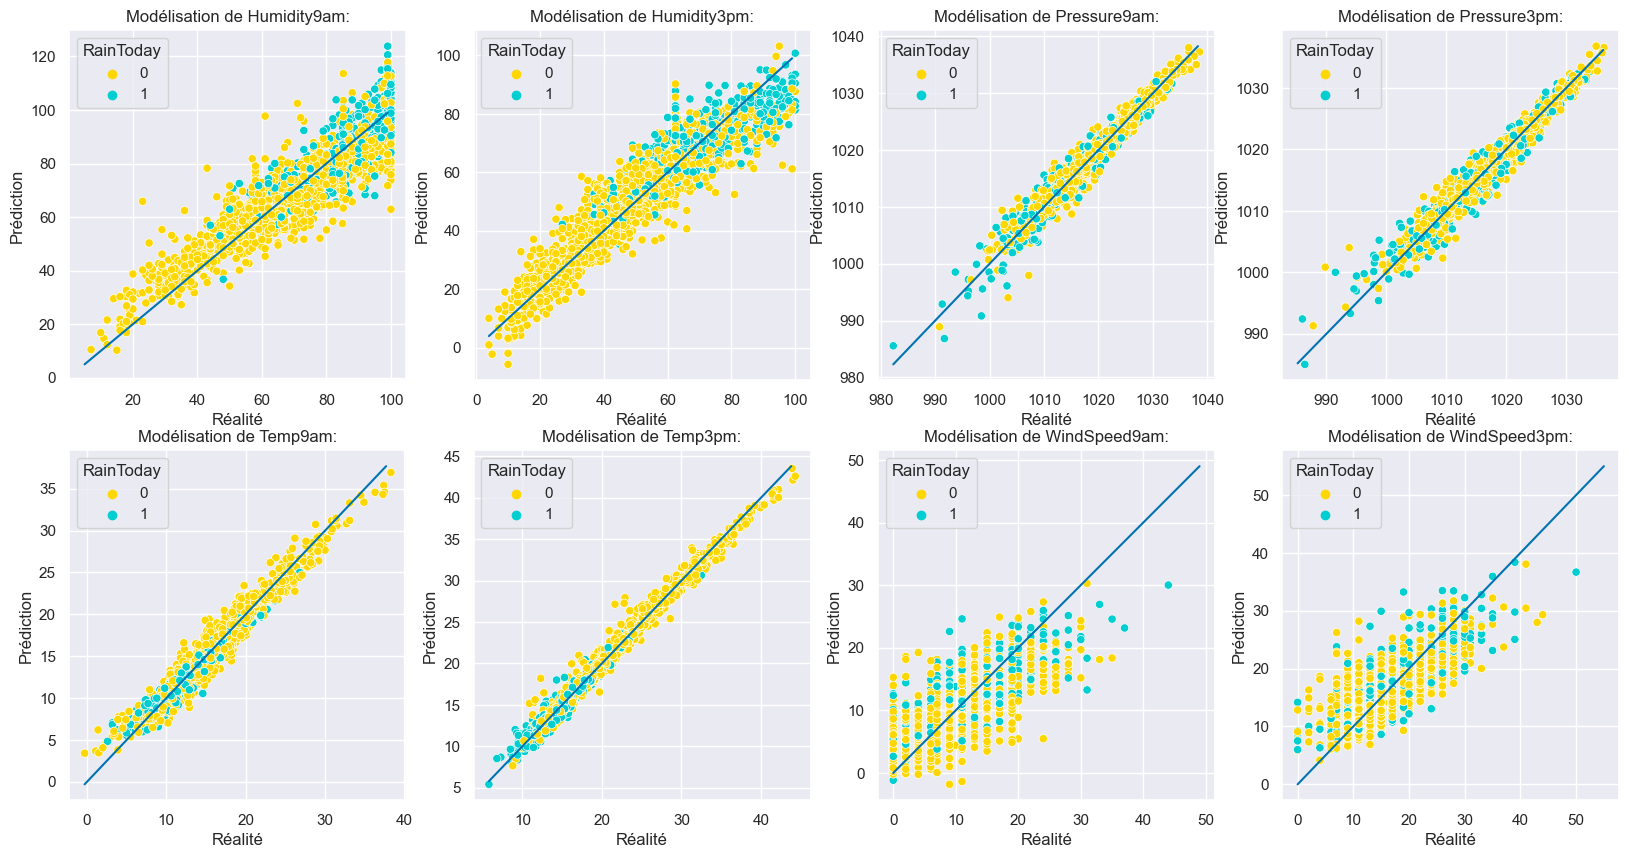

In [216]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i, mesure in enumerate(to_plot):
    
    (y_test, y_pred_test, score_train, score_test, X_test, y) = linreg_plot(mesure, False)
    
    axes = axes.flatten()
    axe = axes[i]
    
    sns.scatterplot(ax = axe, x = y_test, y = y_pred_test, hue = X_test['RainToday'], palette = ['gold', 'darkturquoise'])
    axe.plot(np.arange(y.min(), y.max()), np.arange(y.min(), y.max()))
    
    axe.set_xlabel('Réalité')
    axe.set_ylabel('Prédiction')
    axe.set_title('Modélisation de ' +str(mesure)+ ':')
    #axe.set_text(y.max()*0.6, y.max()*0.15,  "R² sur LR train: " + str(score_train))
    #axe.set_text(y.max()*0.6, y.max()*0.05,  "R² sur LR test CV : " + str(score_test))
    
plt.show()